## Clustering Statistics

This notebook demonstrates how to calculate the 2-point clustering statistics from DESI data. To generate the window power spectrum, the following are required:
- Number of random mocks: ELG: 10; LRG: 8 ;QSO: 4 (clustering.ran.fits)
- One data file. (clustering.dat.fits)

This notebook also provides how to train the emulators and use the profiler. 

The power spectrum is calculated with`compute_pk.sh`, using the `cosmodesi` environment and the `pkrun.py` to compute the power spectrum.

In [1]:
# loading the desilike enviroment
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, FOLPSRCTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import plotting
from desilike import setup_logging
setup_logging()

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

2024-10-21 19:23:14.145674: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# vairables for pk calculation
tracer = "ELG_LOPnotqso" 
ran_mock_num = "10" # ELG:10; LRG:8; QSO:4
region = "NGC"  # NGC or SGC
mocks_fn = os.path.join(os.environ['SCRATCH'], "mocks/")
pk_dir = os.path.join(os.environ['SCRATCH'], "data/pk/")
# pk_dir = os.path.join(os.environ['HOME'], "project_rc/main/data/pk/")
output_dir = '/global/homes/s/shengyu/project_rc/main/results'
cov_dir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/'

# load the pk file, the pk calculated from the pkrun.py
pk_fn = pk_dir+f'pkpoles_{tracer}_{region}_0.8_1.1_default_FKP_lin_thetacut0.05.npy'
wmatrix_fn = pk_dir+f'wmatrix_smooth_{tracer}_{region}_0.8_1.1_default_FKP_lin_thetacut0.05.npy'

# load the covariance matrix from the Ezmocks
cov_fns = []
cov_fn = f'pkpoles_ELG_LOP_{region}_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy'
for i in range(100, 200):
    mock_dir = f'mock{i}/pk/'
    cov_fns.extend(glob.glob(os.path.join(cov_dir,  mock_dir, cov_fn), recursive=True))

In [3]:
# set the k bins
kmin     = 0.005
kmax     = 0.205
binning  = 0.005
k_ev     = np.arange(kmin, kmax, binning)
klen     = len(k_ev)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}
print(k_ev)

cosmo = DESI()
template = DirectPowerSpectrumTemplate(fiducial='DESI')
theory = FOLPSRCTracerPowerSpectrumMultipoles(template=template)
print(theory.varied_params)
observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                     klim=klim, 
                                                     covariance = cov_fns,
                                                     theory=theory,
                                                     kin=np.arange(0.001, 0.35, 0.002),
                                                     wmatrix=wmatrix_fn)
likelihood = ObservablesGaussianLikelihood(observable)
likelihood()

[0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12
 0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175 0.18
 0.185 0.19  0.195 0.2  ]


ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'fc'])
[000003.65] [0/1] 10-21 19:23  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/data/pk/pkpoles_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000003.85] [0/1] 10-21 19:23  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/des

Array(-1273.07997761, dtype=float64)

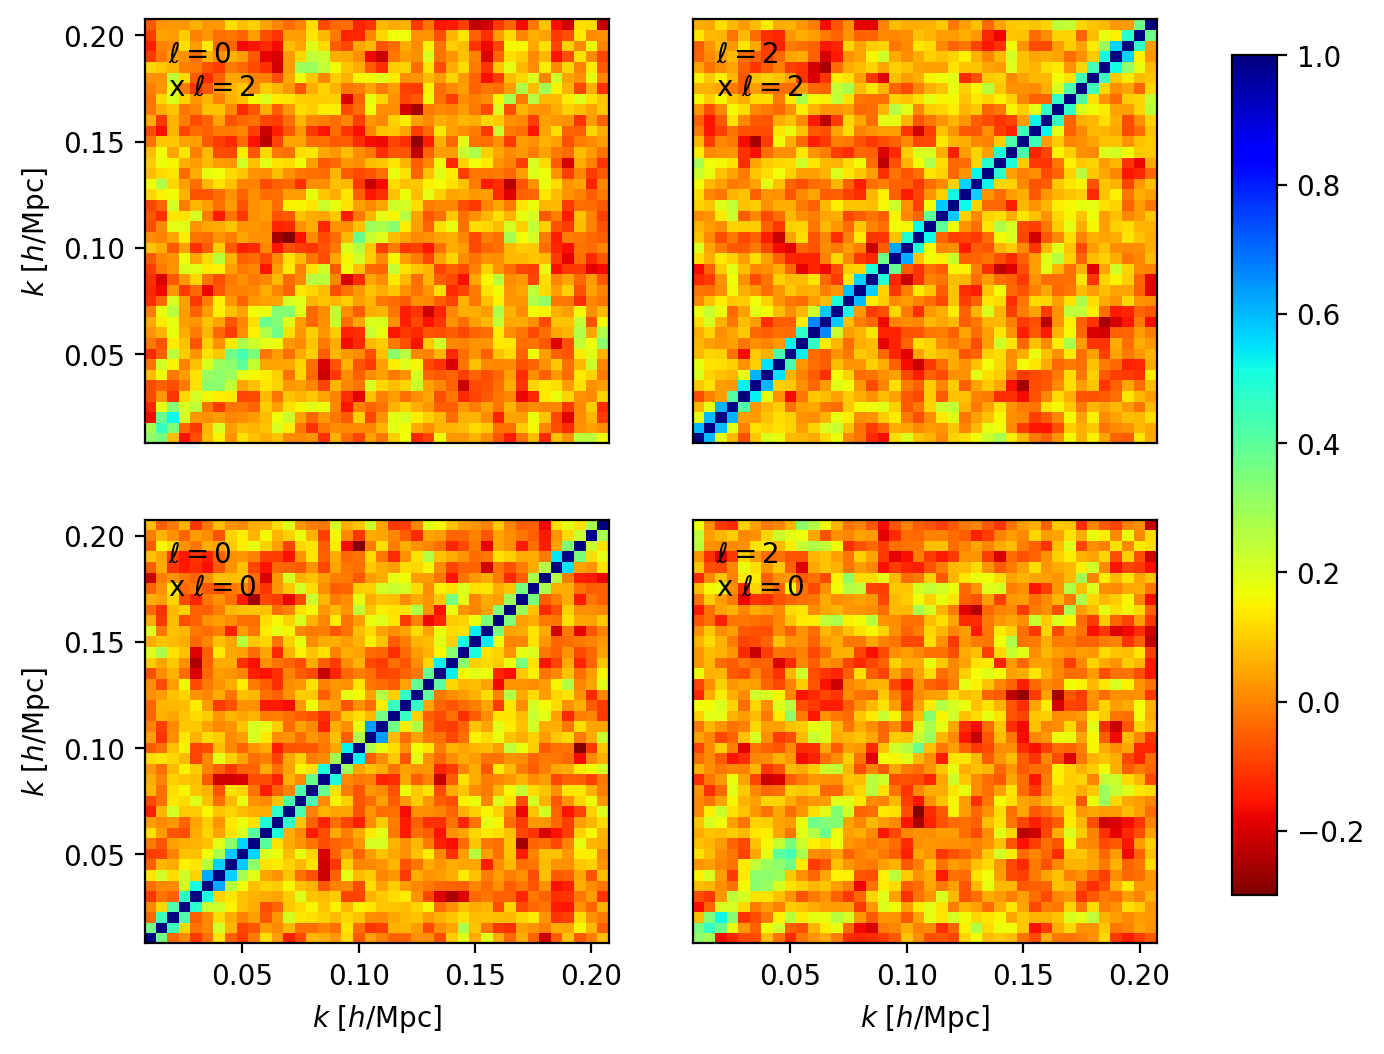

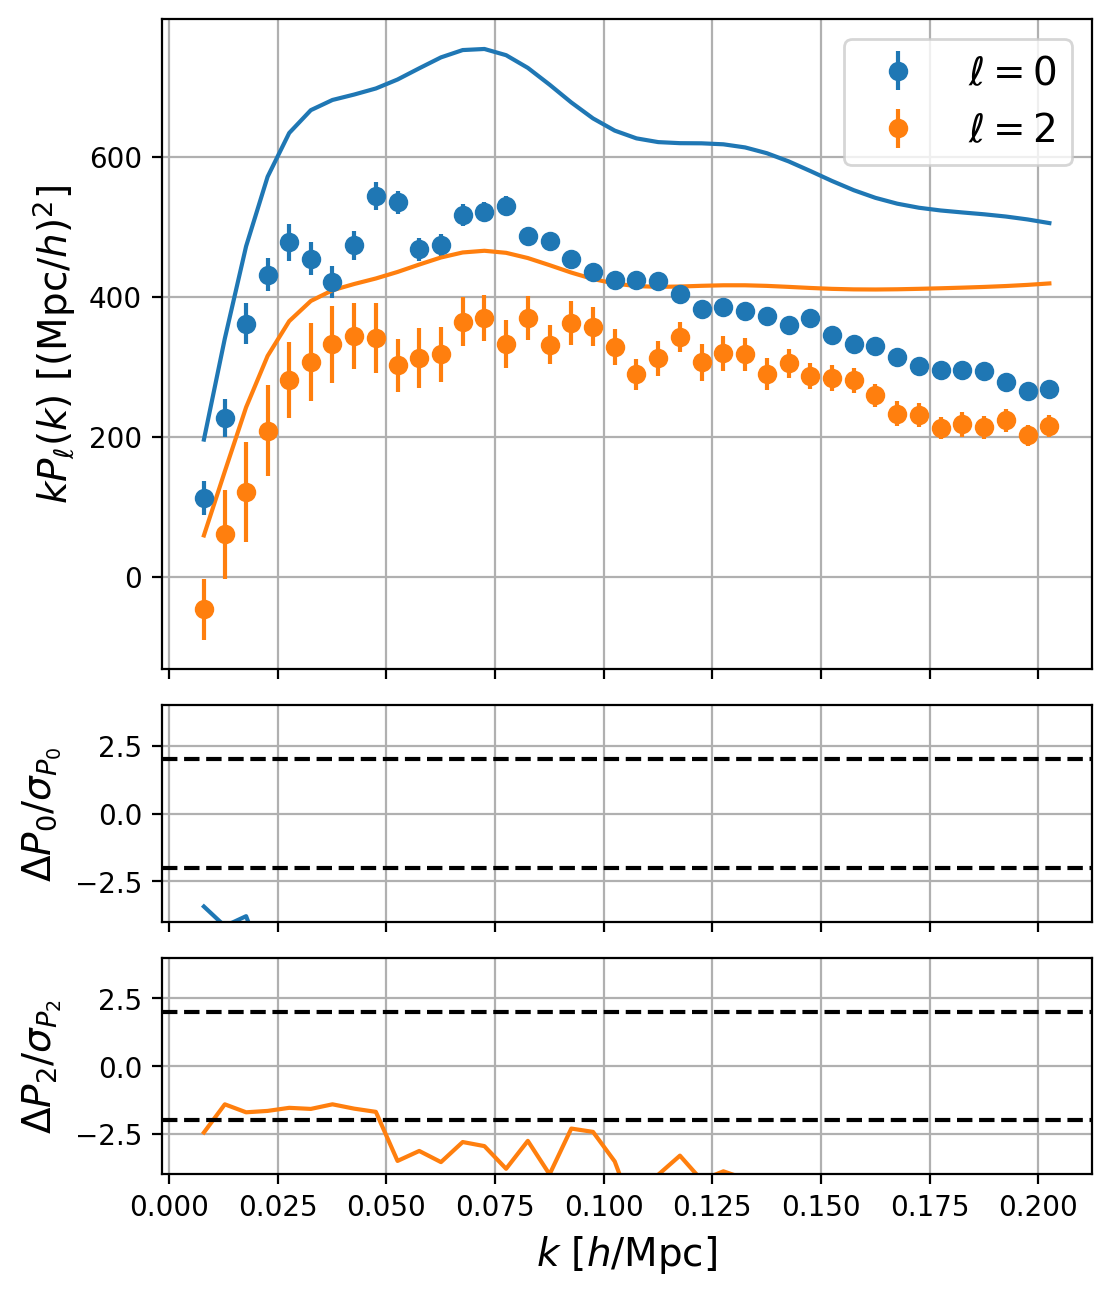

In [4]:
fig_cov = observable.plot_covariance_matrix()
fig_pk = observable.plot()

In [5]:
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine

redshift = 1.0
cosmology = 'LCDM' #LCDM, nuCDM, wCDM
theory_model = 'FOLPS'  # TNS, FOLPS, FOLPSRC
emulator_fn = f'./results/emulators/emulator_{cosmology}_{theory_model}.npy'

def initialize_template(redshift, cosmology):
    cosmo = DESI()
    template = DirectPowerSpectrumTemplate(z=redshift, fiducial='DESI')
    if cosmology == 'nuCDM':
        template.init.params['m_ncdm'].update(fixed=False, latex=r'M_\nu', prior = {'limits': [0.0,1.0]})
    elif cosmology == 'nsCDM':
        template.init.params['n_s'].update(fixed=False)
    elif cosmology == 'wCDM':
        template.init.params['w0_fld'].update(fixed=False)
    return template

# os.remove(emulator_fn)
if not os.path.exists(emulator_fn):
    cosmo = DESI()
    template = initialize_template(redshift, cosmology)
    if theory_model =='FOLPS':
        theory = FOLPSTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    elif theory_model =='FOLPSRC':
        theory = FOLPSRCTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    print(theory.varied_params)
    # footprint = BoxFootprint(volume=1e10, nbar=1e-3)
    # covariance = ObservablesCovarianceMatrix(cov_fns, footprints=footprint)()
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory = theory,
                                                        kin=np.arange(0.001, 0.35, 0.002),
                                                        wmatrix=wmatrix_fn)
    likelihood = ObservablesGaussianLikelihood(observable)
    likelihood()
    emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
    emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
    emulator.fit()
    emulator.save(emulator_fn)
    print("Training emmulator finished")

ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2'])
[000025.66] [0/1] 10-21 19:23  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/data/pk/pkpoles_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000025.68] [0/1] 10-21 19:23  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/surv

[000028.03] [0/1] 10-21 19:23  MeshFFTWindow             INFO     Loading /pscratch/sd/s/shengyu/data/pk/wmatrix_smooth_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy.
[000028.10] [0/1] 10-21 19:23  BaseMatrix                INFO     Loading /pscratch/sd/s/shengyu/data/pk/wmatrix_smooth_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy.
[000033.20] [0/1] 10-21 19:23  ObservablesGaussianLikelihood INFO     Covariance matrix with 80 points built from 100 observations.
[000033.21] [0/1] 10-21 19:23  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.1818.
[000036.24] [0/1] 10-21 19:23  ObservablesGaussianLikelihood INFO     Covariance matrix with 80 points built from 100 observations, varying 12 parameters.
[000036.24] [0/1] 10-21 19:23  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 2.8296.
[000043.14] [0/1] 10-21 19:23  Emulator                  INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b',

In [6]:
theory_el = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn), k=k_ev)
print(theory_el(h = 0.7))

[000101.59] [0/1] 10-21 19:24  Emulator                  INFO     Loading ./results/emulators/emulator_LCDM_FOLPS.npy.
[[ 4862.3146028  12834.88646641 18850.05181714 23280.07694374
  26436.08215116 28559.49070462 29840.12658611 30435.11184013
  30477.64449063 30082.72242575 29350.2715189  28370.59528852
  27222.22724141 25972.70701388 24678.86093559 23386.70959697
  22133.25543726 20944.75320513 19839.82812501 18830.61169043
  17921.41153638 17111.86878577 16398.65021034 15773.81096225
  15229.03977708 14752.31927792 14333.74726194 13960.12226149
  13620.35379402 13303.48599607 12999.49618567 12699.9723671
  12397.93140367 12088.12657398 11766.87429287 11433.11169831
  11086.27032071 10727.81343767 10361.02712055  9989.17660522
   9616.45608436  9247.45277102  8886.5477298   8538.03541252
   8205.58763536  7891.75936423  7599.11076497  7329.82860474
   7083.94498407  6860.81990444  6660.72231812  6482.99450518
   6325.04958906  6184.41841112  6059.33365335  5947.61575589
   5846.429171

In [7]:
from desilike.profilers import MinuitProfiler
from desilike.samples import Profiles

profile_fn = f'./results/profiles/{cosmology}/profiles_{tracer}_{region}_z{redshift}.npy'   
 
# os.remove(profile_fn)
if not os.path.exists(profile_fn):
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory=theory_el,
                                                        kin=np.arange(0.001, 0.35, 0.002),
                                                        wmatrix=wmatrix_fn)
    likelihood = ObservablesGaussianLikelihood(observable, theory=theory_el)
    likelihood() 
    profiler = MinuitProfiler(likelihood, seed=42)
    profiles = profiler.maximize()
    profiles.save(profile_fn)
    print("Profiler finished")
profiles = Profiles.load(profile_fn)
print(profiles.to_stats(tablefmt='pretty'))

[000102.49] [0/1] 10-21 19:24  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/data/pk/pkpoles_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000102.54] [0/1] 10-21 19:24  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock160/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nr

[000104.08] [0/1] 10-21 19:24  MeshFFTWindow             INFO     Loading /pscratch/sd/s/shengyu/data/pk/wmatrix_smooth_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy.
[000104.22] [0/1] 10-21 19:24  BaseMatrix                INFO     Loading /pscratch/sd/s/shengyu/data/pk/wmatrix_smooth_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy.
[000109.33] [0/1] 10-21 19:25  ObservablesGaussianLikelihood INFO     Covariance matrix with 80 points built from 100 observations.
[000109.33] [0/1] 10-21 19:25  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.1818.
[000109.42] [0/1] 10-21 19:25  ObservablesGaussianLikelihood INFO     Covariance matrix with 80 points built from 100 observations, varying 12 parameters.
[000109.43] [0/1] 10-21 19:25  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 2.8296.
[000109.53] [0/1] 10-21 19:25  MinuitProfiler            INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b',

E1021 19:25:06.238697 1496286 pjrt_stream_executor_client.cc:2985] Execution of replica 0 failed: INTERNAL: Failed to allocate 7644000 bytes for new constant


[000255.82] [0/1] 10-21 19:27  Profiles                  INFO     Saving ./results/profiles/LCDM/profiles_ELG_LOPnotqso_NGC_z1.0.npy.
Profiler finished
[000255.82] [0/1] 10-21 19:27  Profiles                  INFO     Loading ./results/profiles/LCDM/profiles_ELG_LOPnotqso_NGC_z1.0.npy.
+--------------------------------------+--------+---------+--------+
| chi2 / (80 - 12) = 20.23 / 68 = 0.30 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                  h                   |  True  |  0.742  | 0.035  |
|              omega_cdm               |  True  |  0.088  | 0.010  |
|               omega_b                |  True  | 0.02237 | 3.7e-4 |
|                 logA                 |  True  |  2.090  | 0.074  |
|                  b1                  |  True  |  2.39   |  0.23  |
|                  b2                  |  True  |   7.7   |  3.0   |
|                  bs                  |  True  |  -31.6  |  9.1   |
|                alpha0

[000255.85] [0/1] 10-21 19:27  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/data/pk/pkpoles_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000255.87] [0/1] 10-21 19:27  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock160/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nr

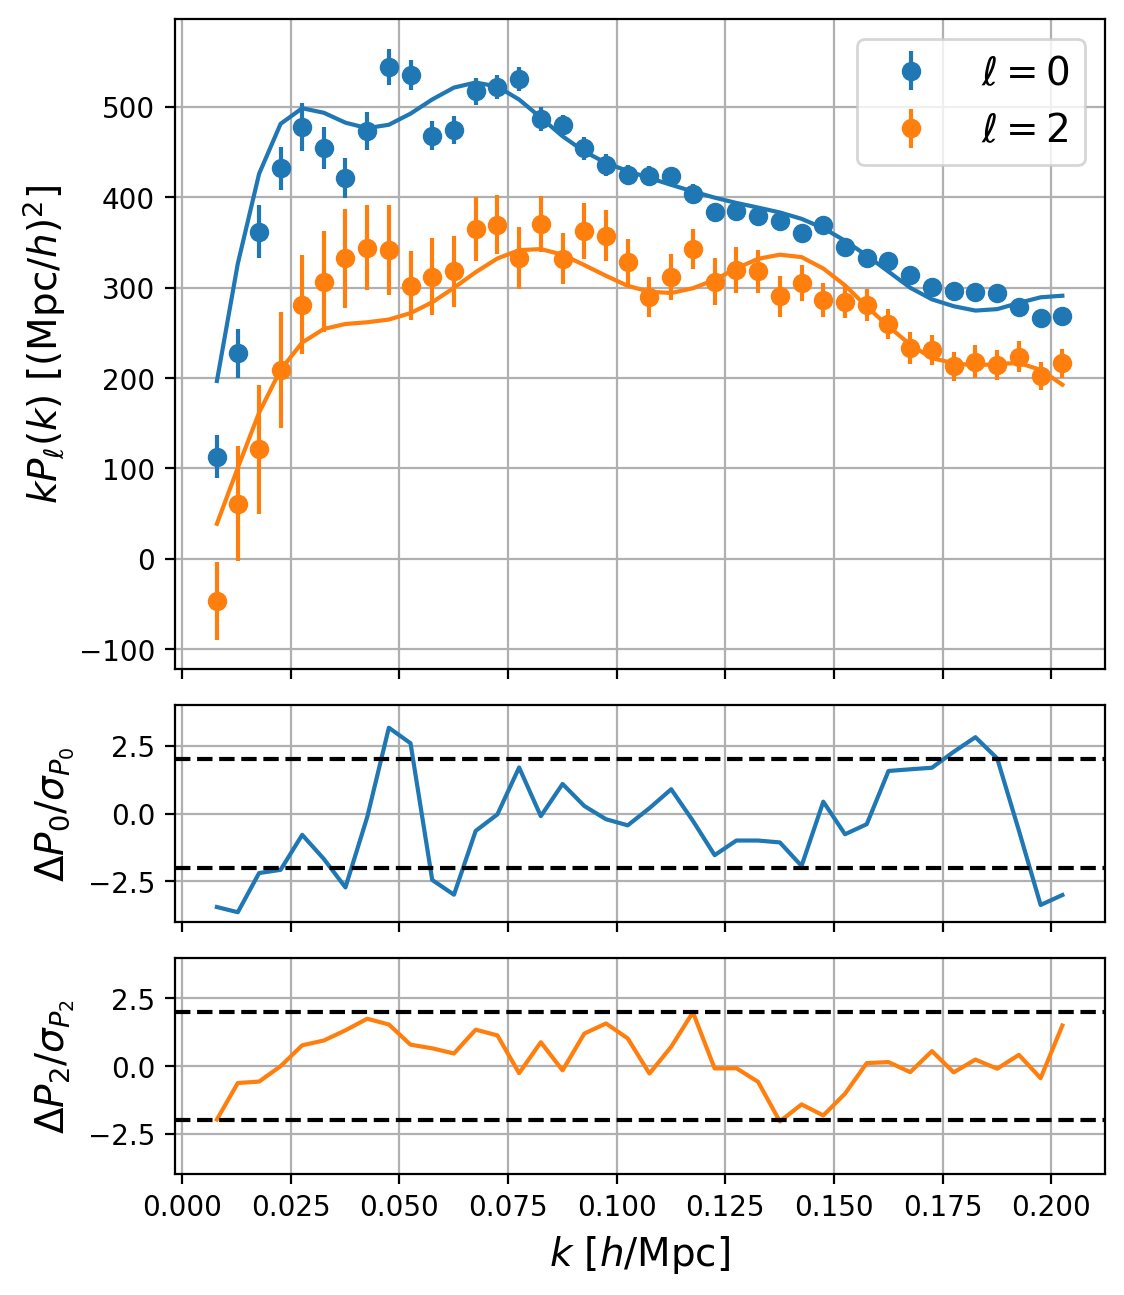

In [8]:
observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                    klim=klim, 
                                                    covariance = cov_fns,
                                                    theory=theory_el,
                                                    kin=np.arange(0.001, 0.35, 0.002),
                                                    wmatrix=wmatrix_fn)
likelihood = ObservablesGaussianLikelihood(observable, theory=theory_el)
print(likelihood(**profiles.bestfit.choice(input=True)))
profiler = MinuitProfiler(likelihood, seed=42)
fig = observable.plot()

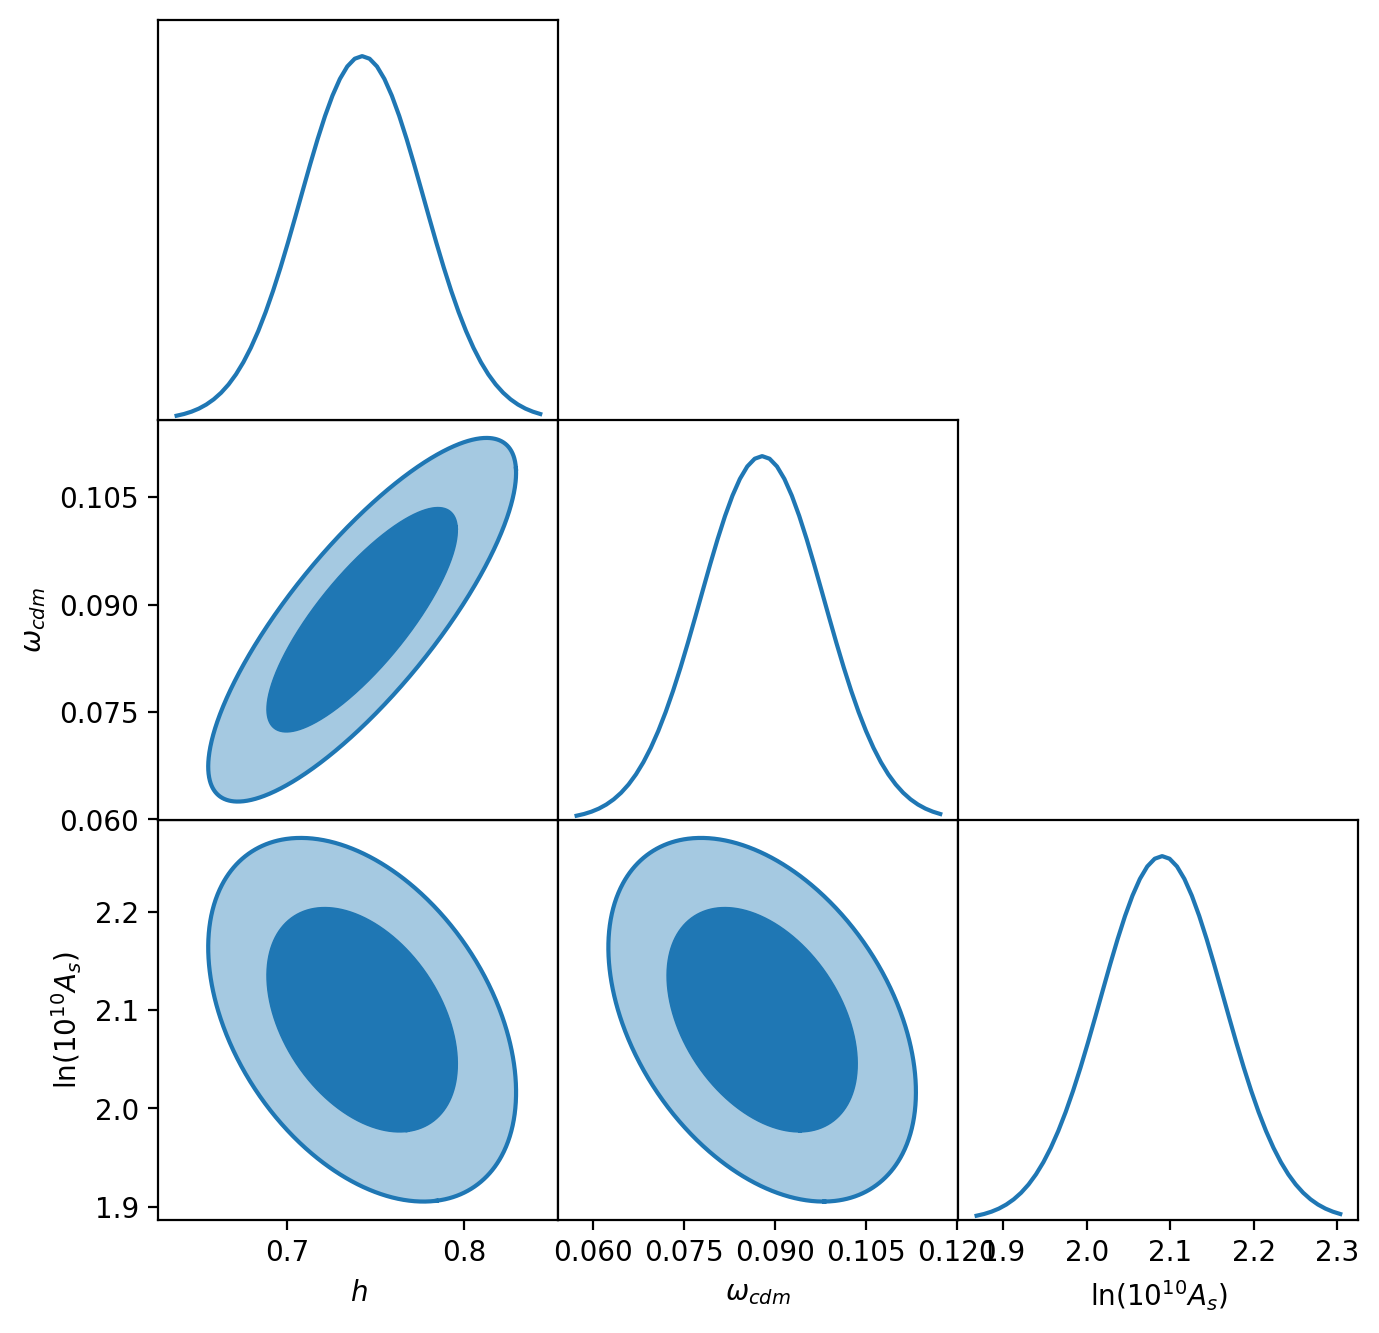

In [9]:
# plot the posterior distribution
from desilike.samples import plotting
fig =plotting.plot_triangle_contours(profiles, params=['h','omega_cdm','logA'], filled=True)